In [1]:
import requests
from PIL import Image
import matplotlib.pyplot as plt
import torch
import numpy as np

from transformers import SamModel, SamProcessor
from transformers import CLIPVisionModel
import torchvision.transforms as T
import torch.nn.functional as F

import math
import os
import tiktoken

from torch.utils.data import DataLoader, Dataset

from deepencoder import CLIP_modified, conv_block, DeepEncoder
from dataloader import OCR_dataset, ocr_collate
from tqdm import tqdm

from helper import text_to_token_ids, token_ids_to_text, download_and_load_gpt2
from knowledge_transfer import load_weights_into_gpt_modified
from model import GPTModel

from pipeline import *

/Users/mohamedmafaz/Desktop/OCR Model/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
train_frac = 0.8
test_frac  = 0.15

batch_size = 1
device = "cpu"

In [3]:
tokenizer = tiktoken.get_encoding('gpt2')

special_tokens = {"<image>": tokenizer.n_vocab+1}
tokenizer_modified = tiktoken.Encoding(
    name="gpt2_with_image",
    pat_str=tokenizer._pat_str,
    mergeable_ranks=tokenizer._mergeable_ranks,
    special_tokens={**tokenizer._special_tokens, **special_tokens}
)
vocab_size = tokenizer_modified.n_vocab
vocab_size

50259

In [4]:
files = os.listdir('dataset')[:20]
l = len(files)

# train_frac = 0.8
# test_frac  = 0.15

train_pos = int(l * train_frac)
test_pos  = int(l * test_frac)

train_files = files[: train_pos]
test_files = files[train_pos : train_pos + test_pos]
val_files  = files[train_pos + test_pos : ]

len(train_files), len(test_files), len(val_files)

(16, 3, 1)

In [6]:
train_dl = DataLoader(
           dataset=OCR_dataset(
               dataset_file_name = 'dataset',
               files = train_files,
               tokenizer = tokenizer_modified
               ),
           batch_size=batch_size,
           shuffle=True,
           collate_fn=ocr_collate,
           pin_memory=True,
           drop_last = True
       )

test_dl  = DataLoader(
           dataset=OCR_dataset(
               dataset_file_name = 'dataset',
               files = test_files,
               tokenizer = tokenizer_modified
               ),
           batch_size=batch_size,
           shuffle=False,
           collate_fn=ocr_collate,
           pin_memory=True,
           drop_last = True
       )

val_dl  =  DataLoader(
           dataset=OCR_dataset(
               dataset_file_name = 'dataset',
               files = val_files,
               tokenizer = tokenizer_modified
               ),
           batch_size=batch_size,
           shuffle=False,
           collate_fn=ocr_collate,
           pin_memory=True,
           drop_last = True
       )

one_batch  = next(iter(train_dl))

one_batch_input_ids  = one_batch["input_ids"]
one_batch_target_ids =  one_batch["target_ids"]
one_batch_images     = one_batch["images"]

print(f"input_ids: {one_batch_input_ids.shape}")
print(f"target_ids: {one_batch_target_ids.shape}")
print(f"images: {one_batch_images.shape}")



input_ids: torch.Size([1, 16])
target_ids: torch.Size([1, 16])
images: torch.Size([1, 3, 1024, 1024])


In [7]:
sam_model = SamModel.from_pretrained("facebook/sam-vit-base").to(device)
clip_model = CLIPVisionModel.from_pretrained("openai/clip-vit-large-patch14").to(device)
deep_encoder = DeepEncoder(sam_model = sam_model, clip_model = clip_model)
deep_encoder

SAM params: 93,735,472
CLIP params: 303,179,776

In [8]:
GPT_CONFIG_124M = {
    "vocab_size"     : tokenizer.n_vocab,     # 50257
    "context_length" : 1024,                  # The maximum number of tokens the model can process at once
    "embedding_dim"  : 768,                   # The number of features used to represent each token 
    "n_heads"        : 12,
    "n_layers"       : 12,                    # How many transformer blocks
    "drop_rate"      : 0.1,
    "qkv_bias"       : False
}

model_configs = {
    "gpt2-small (124M)": {"embedding_dim": 768, "n_layers": 12, "n_heads": 12},
    "gpt2-medium (355M)": {"embedding_dim": 1024, "n_layers": 24, "n_heads": 16},
    "gpt2-large (774M)": {"embedding_dim": 1280, "n_layers": 36, "n_heads": 20},
    "gpt2-xl (1558M)": {"embedding_dim": 1600, "n_layers": 48, "n_heads": 25},
}

model_name = "gpt2-large (774M)"

NEW_CONFIG = GPT_CONFIG_124M.copy()
NEW_CONFIG.update(model_configs[model_name])
NEW_CONFIG.update({"context_length": 1024, 
                   "qkv_bias": True, 
                   "vocab_size": tokenizer_modified.n_vocab,
                   "vision_dim": 1280})

settings, params = download_and_load_gpt2(model_size="774M", models_dir="gpt2")
gpt2 = GPTModel(NEW_CONFIG)
load_weights_into_gpt_modified(gpt2, params)
gpt2.token_embedding

File already exists and is up-to-date: gpt2/774M/checkpoint
File already exists and is up-to-date: gpt2/774M/encoder.json
File already exists and is up-to-date: gpt2/774M/hparams.json
File already exists and is up-to-date: gpt2/774M/model.ckpt.data-00000-of-00001
File already exists and is up-to-date: gpt2/774M/model.ckpt.index
File already exists and is up-to-date: gpt2/774M/model.ckpt.meta
File already exists and is up-to-date: gpt2/774M/vocab.bpe


Embedding(50259, 1280)

In [9]:
# logits = vision_pipeline(deep_encoder   = deep_encoder,
#                         deep_decoder    = gpt2,
#                         input_ids_batch = one_batch_input_ids,
#                         image_batch     = one_batch_images,
#                         tokenizer       = tokenizer_modified
#                         )
# logits.shape

In [10]:
# loss = calc_loss_batch(pipline = vision_pipeline,
#                        deep_encoder = deep_encoder,
#                        deep_decoder = gpt2,
#                        input_batch  = one_batch_input_ids,
#                        target_batch = one_batch_target_ids,
#                        image_batch  = one_batch_images,
#                        tokenizer    = tokenizer_modified
#                        )
# loss

In [11]:
# batch_loss = calc_loss_loader(dataloader   = train_dl,
#                               deep_encoder = deep_encoder,
#                               deep_decoder = gpt2,
#                               tokenizer    = tokenizer_modified,
#                               num_batches  = 1)
# batch_loss

In [12]:
# sample_gen = generate_and_print_samples(model          = gpt2,
#                                         device         = device,
#                                         tokenizer      = tokenizer_modified,
#                                         start_context  = "airplane is",
#                                         cfg            = NEW_CONFIG,
#                                         max_new_tokens = 4)

# sample_gen

In [ ]:
def train(train_loader, val_loader, 
          deep_encoder, deep_decoder, cfg,
          optimizer, device, num_epochs, 
          eval_freq, eval_itter, 
          tokenizer, 
          verbose = True, max_new_tokens = 50, 
          save_itter = 5, 
          save_path = "gpt2/OCR_finetuned/gpt2_774M_finetuned.pth",
          load_pretained = True,
          ):
    
    train_losses, val_losses, track_tokens_seen = [], [], []
    tokens_seen, global_step = 0, -1

    if load_pretained:
        checkpoint = torch.load(save_path, map_location="cpu")

        epoch_continue = checkpoint["epoch"]
        deep_decoder.load_state_dict(checkpoint["model_state"])
        print("loaded")
        
    else:
        epoch_continue = 0

    for epoch in range(epoch_continue, num_epochs + epoch_continue):
        deep_decoder.train()
        local_step = 0
        for idx, a in enumerate(train_loader):
            
            input_batch  = a["input_ids"]
            target_batch = a["target_ids"]
            image_batch  = a["images"]

            optimizer.zero_grad()

            loss = calc_loss_batch(pipline      = vision_pipeline,
                                   deep_encoder = deep_encoder,
                                   deep_decoder = deep_decoder,
                                   input_batch  = input_batch,
                                   target_batch = target_batch,
                                   image_batch  = image_batch,
                                   tokenizer    = tokenizer
                                   )
            
            loss.backward()

            optimizer.step()
            tokens_seen = input_batch.numel()
            global_step += 1

            if global_step % eval_freq == 0:
                deep_decoder.eval()
                with torch.no_grad():
                    train_loss = calc_loss_loader(dataloader   = train_loader,
                                                  deep_encoder = deep_encoder,
                                                  deep_decoder = deep_decoder,
                                                  tokenizer    = tokenizer,
                                                  num_batches  = eval_itter,
                                                  pipeline     = vision_pipeline)
                
                    val_loss   = calc_loss_loader(dataloader   = val_loader,
                                                  deep_encoder = deep_encoder,
                                                  deep_decoder = deep_decoder,
                                                  tokenizer    = tokenizer,
                                                  num_batches  = eval_itter,
                                                  pipeline     = vision_pipeline)
                deep_decoder.train()
                train_losses.append(train_loss)
                val_losses.append(val_loss)
                track_tokens_seen.append(tokens_seen)

                print(f"Ep {epoch+1} (Step {global_step:06d}): "
                        f"Train loss {train_loss:.3f}, Val loss {val_loss:.3f}"
                    )
            local_step += 1
            if local_step % save_itter == 0:
                checkpoint = {
                                "epoch"          : epoch,
                                "model_state"    : deep_decoder.state_dict(),
                             }

                torch.save(checkpoint, save_path)
                if verbose: print("saved")
                
        # print some samples
        if verbose:
            text = generate_text(
                        deep_encoder   = deep_encoder,
                        gpt2           = gpt2,
                        projector      = deep_encoder.projector,
                        tokenizer      = tokenizer_modified,
                        image          = next(iter(val_dl))['images'][0],
                        prompt         = "<image>\n",
                        max_new_tokens = max_new_tokens,
                        temperature    = 1.5,
                        top_k          = 50,
                        device         = device
                    )
            
            print(text.replace("\n", " "))
            
    return train_losses, val_losses, track_tokens_seen

In [ ]:
optimizer = torch.optim.AdamW(gpt2.parameters(), lr=0.00005, weight_decay=0.1)
num_epochs = 2

train_losses, val_losses, tokens_seen = train(train_loader   = train_dl,
                                              val_loader     = val_dl,
                                              deep_encoder   = deep_encoder,
                                              deep_decoder   = gpt2,
                                              cfg            = NEW_CONFIG,
                                              device         = device,
                                              num_epochs     = num_epochs,
                                              eval_freq      = 5,
                                              eval_itter     = 2,
                                              start_context  = "I HAD",
                                              tokenizer      = tokenizer_modified,
                                              verbose        = True,
                                              optimizer      = optimizer,
                                              max_new_tokens = 10,
                                              save_itter     = 1,
                                              save_path      = "gpt2/OCR_finetuned/gpt2_774M_finetuned.pth",
                                              load_pretained = True,
                                              verbose        = True)

In [9]:
a = next(iter(train_dl))
sample_input_ids  = a["input_ids"]
sample_target_ids = a["target_ids"]
sample_images     = a["images"]

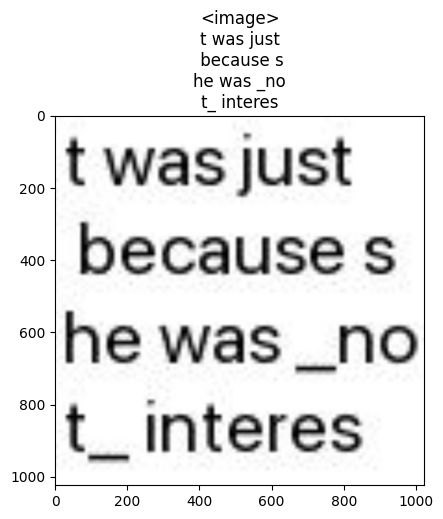

In [16]:
plt.imshow(
    sample_images.squeeze(0).permute(1,2,0).cpu().detach().numpy()
)
plt.title(token_ids_to_text(sample_input_ids, tokenizer_modified))
plt.show()

In [17]:
token_ids_to_text(sample_input_ids, tokenizer_modified)

'<image>\nt was just\n because s\nhe was _no\nt_ interes'

In [23]:
text = generate_text(
    deep_encoder   = deep_encoder,
    gpt2           = gpt2,
    projector      = deep_encoder.projector,
    tokenizer      = tokenizer_modified,
    image          = one_batch_images,
    prompt         = "<image>\n",
    max_new_tokens = 5,
    temperature    = 0.6,
    top_k          = 100,
    device         = "cpu"
)

print(f"{text}")

Generating samples: 5: 100%|██████████| 5/5 [02:54<00:00, 34.88s/it]





">


In [24]:
text

'\n\n\n\n">'